In [2]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
num_classes = 10 
num_features = 784 
learning_rate = 0.001 
training_steps = 3000 
batch_size = 256 
display_step = 100 
n_hidden_1 = 128 
n_hidden_2 = 256 

In [4]:
from tensorflow.keras.datasets import mnist


(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 3s 0us/step


In [5]:
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)  
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):
    
    x1 = self.layer_1(x, activation=0)
    x2 = self.layer_2(x1, activation=0)
    x3 = self.layer_3(x2, activation=1)
    return x3

In [6]:
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()

In [7]:
neural_net = NN(name="mnist")


def train(nn, input_x, output_y):
    optimizer = tf.optimizers.SGD(learning_rate)

    with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    trainable_variables = nn.trainable_variables

    gradients = g.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [8]:


loss_history = []  
accuracy_history = [] 

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    train(neural_net, batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y)
        loss_history.append(current_loss)
        
        current_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(current_accuracy)
        print(f"Step: {step}, Loss: {current_loss}, Accuracy: {current_accuracy}")

Step: 0, Loss: 3255.323486328125, Accuracy: 0.1015625
Step: 100, Loss: 885.1729736328125, Accuracy: 0.60546875
Step: 200, Loss: 714.9793701171875, Accuracy: 0.671875
Step: 300, Loss: 659.6315307617188, Accuracy: 0.70703125
Step: 400, Loss: 659.6400756835938, Accuracy: 0.734375
Step: 500, Loss: 847.4057006835938, Accuracy: 0.76171875
Step: 600, Loss: 748.2550048828125, Accuracy: 0.73046875
Step: 700, Loss: 622.6047973632812, Accuracy: 0.79296875
Step: 800, Loss: 672.96484375, Accuracy: 0.7890625
Step: 900, Loss: 734.8743286132812, Accuracy: 0.7578125
Step: 1000, Loss: 700.8311157226562, Accuracy: 0.765625
Step: 1100, Loss: 898.5702514648438, Accuracy: 0.75
Step: 1200, Loss: 679.9340209960938, Accuracy: 0.79296875
Step: 1300, Loss: 721.8975830078125, Accuracy: 0.7578125
Step: 1400, Loss: 705.2589111328125, Accuracy: 0.765625
Step: 1500, Loss: 900.1205444335938, Accuracy: 0.76953125
Step: 1600, Loss: 869.3228759765625, Accuracy: 0.75
Step: 1700, Loss: 600.318603515625, Accuracy: 0.828125


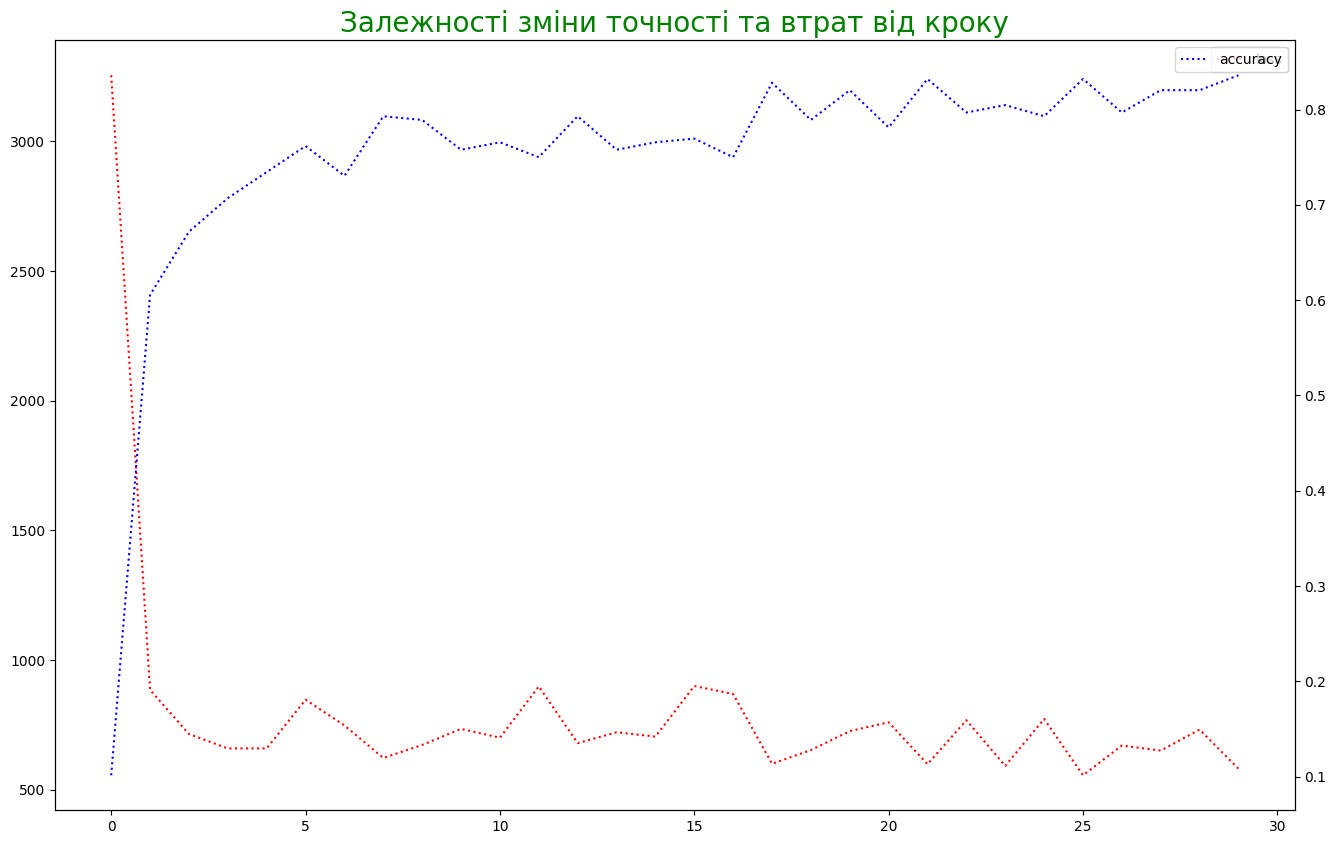

In [10]:
import pandas as pd

fig, axs = plt.subplots(figsize=(16, 10))
axs.plot(loss_history, 'r', label='loss', linestyle=":")
axs.legend()

axs2=axs.twinx()
axs2.plot(accuracy_history, 'b', label='accuracy', linestyle=":")
plt.legend()

plt.title('Залежності зміни точності та втрат від кроку', fontsize=20, color='g')
plt.show()

In [11]:

neural_net_accuracy = accuracy(neural_net(x_train), y_train)
print(f"Accuracy: {neural_net_accuracy}")

Accuracy: 0.8144333362579346


True: 0 Predict: 0 True
True: 6 Predict: 6 True
True: 8 Predict: 8 True
True: 8 Predict: 3 False
True: 6 Predict: 6 True
True: 3 Predict: 3 True
True: 2 Predict: 2 True
True: 8 Predict: 4 False
True: 4 Predict: 4 True
True: 9 Predict: 9 True


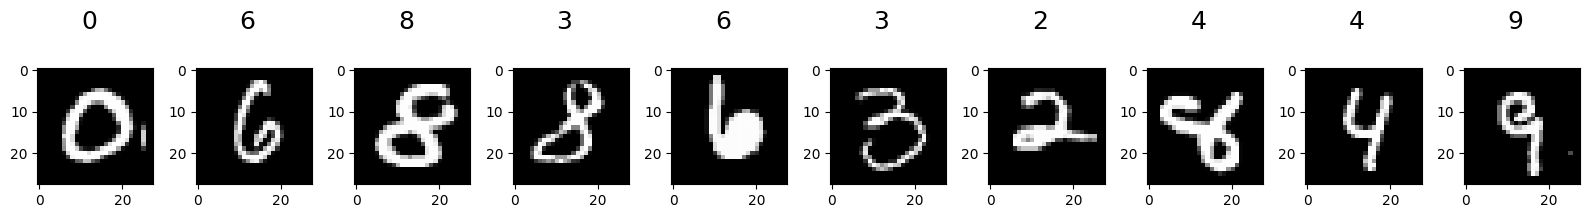

In [12]:


test_img = np.random.permutation(x_test.shape[0])[:10]
y_test_true = y_test[test_img]
pred_data = [np.argmax(x) for x in neural_net(x_test[test_img])]

plt.figure(figsize=(16, 6))
for i in range(10):
    print(f"True: {y_test_true[i]} Predict: {pred_data[i]} {True if y_test_true[i] - pred_data[i] == 0 else False}")
    plt.subplot(1, 10, (i + 1))
    plt.imshow(x_test[test_img[i]].reshape(28, 28), cmap='gray')
    plt.text(x=10, y=-10, s=pred_data[i], fontsize=18)
    
plt.tight_layout()
plt.show()